# Financial Time Series - ETH Price Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

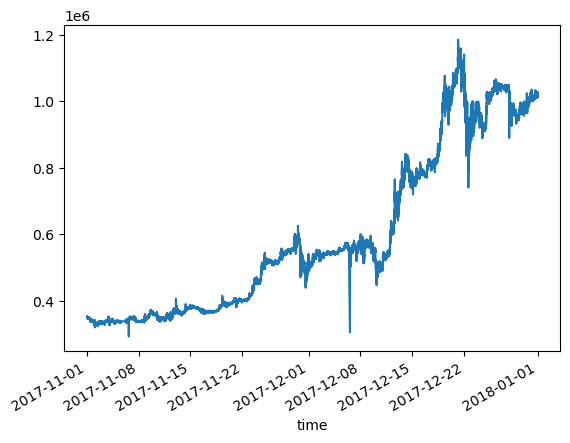

In [4]:
# 데이터 경로
DATA_PATH = '/Users/leegen/Downloads/sub_upbit_eth_min_tick.csv'

# 데이터 불러오기
data = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
data.loc['2017-11-01':'2017-12-31','close'].plot()

# Data Labeling

In [5]:
# Price Change Direction

window = 10

momentum_signal = np.sign(np.sign(data['close'] - data['close'].shift(window)) +1)
s_momentum_signal = pd.Series(momentum_signal, index=data.index)

In [9]:
sub_data = data.loc['2017-11-21', 'close']

c_sig = s_momentum_signal.loc['2017-11-21']
print(c_sig.value_counts())
c_sig['color'] = np.where(c_sig > 0, 'red', 'blue')
print(c_sig)

close
0.0    670
1.0    631
Name: count, dtype: int64
time
2017-11-21 00:00:00                                                  0.0
2017-11-21 00:01:00                                                  0.0
2017-11-21 00:02:00                                                  0.0
2017-11-21 00:03:00                                                  0.0
2017-11-21 00:04:00                                                  0.0
                                             ...                        
2017-11-21 23:56:00                                                  0.0
2017-11-21 23:57:00                                                  0.0
2017-11-21 23:58:00                                                  0.0
2017-11-21 23:59:00                                                  0.0
color                  [blue, blue, blue, blue, blue, blue, blue, blu...
Name: close, Length: 1302, dtype: object


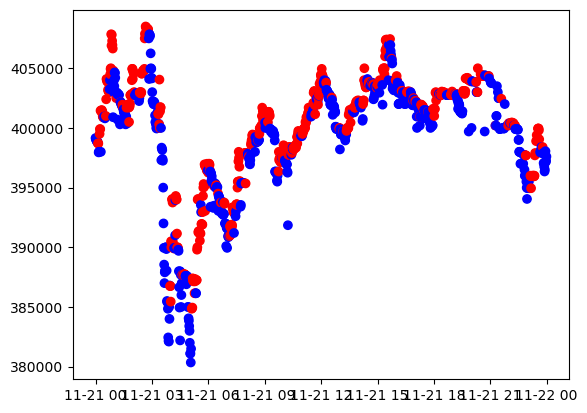

In [10]:
plt.figure()
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [11]:
# moving average

momentum_signal = np.sign(np.sign(data['close'] - data['close'].rolling(window).mean()) +1)
s_momentum_signal = pd.Series(momentum_signal, index=data.index)

In [12]:
sub_data = data.loc['2017-11-21', 'close']

c_sig = s_momentum_signal.loc['2017-11-21']
print(c_sig.value_counts())
c_sig['color'] = np.where(c_sig > 0, 'red', 'blue')
print(c_sig)

close
1.0    677
0.0    624
Name: count, dtype: int64
time
2017-11-21 00:00:00                                                  0.0
2017-11-21 00:01:00                                                  0.0
2017-11-21 00:02:00                                                  0.0
2017-11-21 00:03:00                                                  0.0
2017-11-21 00:04:00                                                  0.0
                                             ...                        
2017-11-21 23:56:00                                                  1.0
2017-11-21 23:57:00                                                  0.0
2017-11-21 23:58:00                                                  1.0
2017-11-21 23:59:00                                                  1.0
color                  [blue, blue, blue, blue, blue, blue, blue, blu...
Name: close, Length: 1302, dtype: object


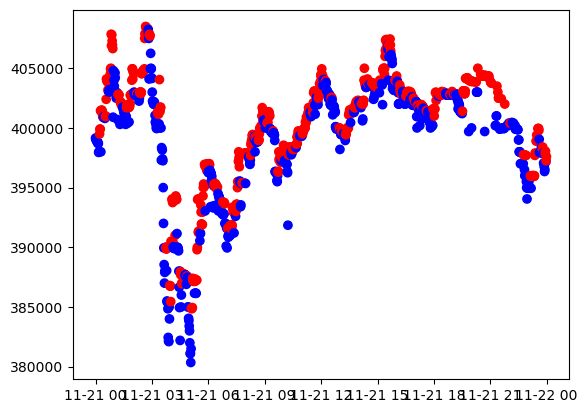

In [13]:
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [16]:
# Local min-MAX

def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes}) 


In [17]:
mins, maxes = get_local_min_max(sub_data)
mins

,min_time,local_min
0,2017-11-21 00:01:00,399050
1,2017-11-21 00:03:00,399000
2,2017-11-21 00:04:00,398900
3,2017-11-21 00:05:00,398850
4,2017-11-21 00:06:00,398800
...,...,...
472,2017-11-21 23:48:00,397850
473,2017-11-21 23:50:00,397050
474,2017-11-21 23:52:00,396750
475,2017-11-21 23:53:00,396350


(376546.5, 412585.0)

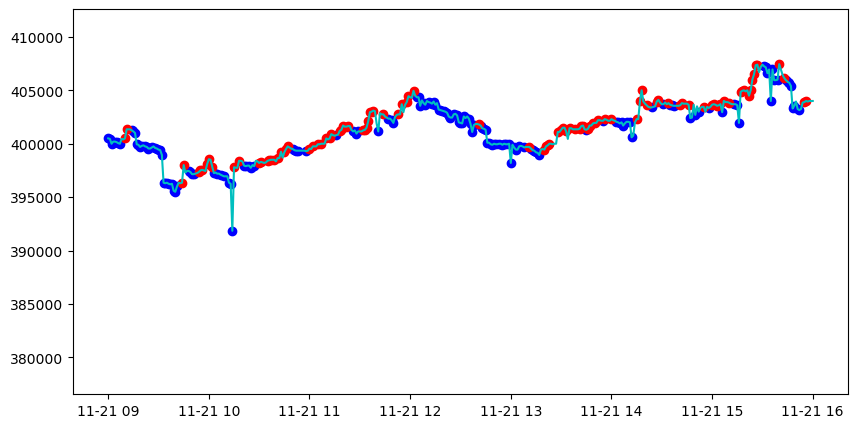

In [24]:
# plot

st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(sub_data.loc[st_time : ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')

ax.set_ylim([sub_data.min() * 0.99 , sub_data.max() * 1.01])

In [25]:
# Trend Scanning

def t_val_lin_r(close):
    import statsmodels.api as sml
    
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    
    return ols.tvalues[1]

In [26]:
look_fwd_window = 60
min_sample_len = 5
step = 1
t1_array = []
t_values_array = []

In [29]:
# Q. 코드를 작성해주세요

# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = data.loc[ind:, 'close'].iloc[:look_fwd_window]  # 전방 탐색을 위한 샘플 추출
    if look_fwd_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_len-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_len, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|████████████████████████████████████| 33384/33384 [05:03<00:00, 109.86it/s]


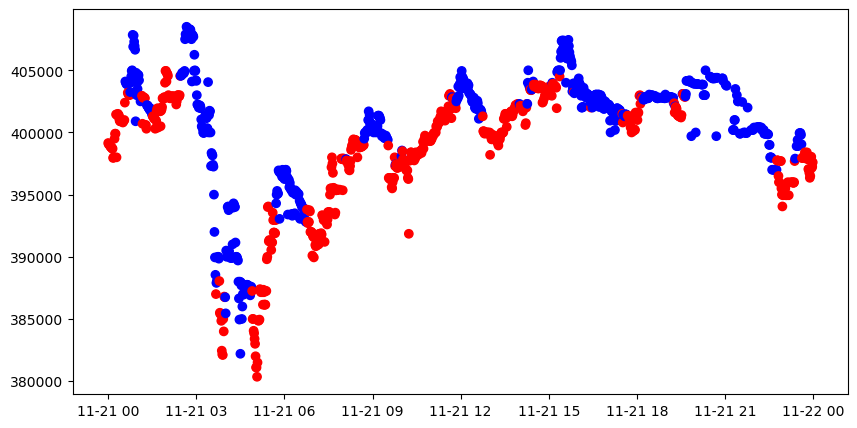

In [30]:
# visualization

sub_data = data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig > 0, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

# Feature Engineering

In [31]:
!pip install ta==0.9.0
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28892 sha256=d1ace946e25f1337030230f837a44f8295a31f33a983bedd9f5d25c247fb7b4b
  Stored in directory: /Users/leegen/Library/Caches/pip/wheels/b5/fd/8d/250a0fe7de9a6bfc9c22235b544c550f9a868b9af79aa7e9ed
Successfully built ta
  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/6f/36/2f5105c5accba2a58a8c6fda8d890fe8de329545f673a4f62235a67d723d/shap-0.44.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for slicer==0.0.7 from https://files.pythonhosted.org/packages/78/c2/b3f55dfdb8af9812fdb9baf70cacf3b9e82e505b2bd4324d588888b81202/slicer-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.2/448.2 kB 9.6 MB/s eta 0:00:00:00:01


In [32]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/Users/leegen/Downloads/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

ModuleNotFoundError: No module named 'libs'